In [ ]:
!pip install vaderSentiment textblob transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Load datasets
stock_df = pd.read_csv('/content/drive/MyDrive/Stock&ETF_dataset/intc.us.txt')
news_2016_df = pd.read_csv('/content/drive/MyDrive/Intel_news/intel_news_2016.csv')
news_2017_df = pd.read_csv('/content/drive/MyDrive/Intel_news/intel_news_2017.csv')

# Convert date columns to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
news_2016_df['date'] = pd.to_datetime(news_2016_df['date'])
news_2017_df['date'] = pd.to_datetime(news_2017_df['date'])

# Verifikasi data
print("Stock data range:", stock_df['Date'].min(), "to", stock_df['Date'].max())
print("2016 News data shape:", news_2016_df.shape)
print("2017 News data shape:", news_2017_df.shape)

Stock data range: 1972-01-07 00:00:00 to 2017-11-10 00:00:00
2016 News data shape: (231, 3)
2017 News data shape: (243, 3)


In [ ]:
def add_technical_indicators(df):
    df = df.copy()

    # Trend Indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()

    # MACD
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + 2*bb_std
    df['BB_lower'] = df['BB_middle'] - 2*bb_std
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']

    # Momentum
    df['ROC'] = df['Close'].pct_change(periods=12) * 100
    df['MOM'] = df['Close'].diff(periods=10)

    # Volume Indicators
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()

    # Volatility
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()

    # Price Channels
    df['Upper_Channel'] = df['High'].rolling(20).max()
    df['Lower_Channel'] = df['Low'].rolling(20).min()

    return df

In [ ]:
def get_enhanced_sentiment(text):
    try:
        # VADER sentiment
        analyzer = SentimentIntensityAnalyzer()
        vader_scores = analyzer.polarity_scores(text)

        # TextBlob sentiment
        blob = TextBlob(str(text))
        textblob_score = blob.sentiment.polarity

        # Transformers sentiment
        sentiment_analyzer = pipeline("sentiment-analysis")
        transformer_result = sentiment_analyzer(str(text)[:512])[0]
        transformer_score = transformer_result['score'] if transformer_result['label'] == 'POSITIVE' else -transformer_result['score']

        # Combine scores
        combined_score = (vader_scores['compound'] + textblob_score + transformer_score) / 3
        return combined_score
    except:
        return 0

def process_sentiment(df):
    # Convert to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Calculate sentiment scores
    df['sentiment_score'] = df['title'].apply(get_enhanced_sentiment)

    # Group by date
    daily_sent = df.groupby('date')['sentiment_score'].agg(['mean', 'count']).reset_index()

    # Generate complete date range
    date_range = pd.date_range(start=daily_sent['date'].min(),
                             end=daily_sent['date'].max(),
                             freq='D')

    # Reindex and fill missing dates
    daily_sent = daily_sent.set_index('date').reindex(date_range).reset_index()
    daily_sent = daily_sent.rename(columns={'index': 'date'})

    # Fill NaN values
    daily_sent['mean'] = daily_sent['mean'].fillna(0)
    daily_sent['count'] = daily_sent['count'].fillna(0)

    # Calculate rolling metrics
    daily_sent['rolling_sentiment'] = daily_sent['mean'].rolling(window=7, min_periods=1).mean()
    daily_sent['rolling_count'] = daily_sent['count'].rolling(window=7, min_periods=1).mean()

    return daily_sent

# Process sentiment data
daily_sentiment_2016 = process_sentiment(news_2016_df)
daily_sentiment_2017 = process_sentiment(news_2017_df)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 7

In [ ]:
# Split stock data
stock_2016 = stock_df[stock_df['Date'].dt.year == 2016].copy()
stock_2017 = stock_df[stock_df['Date'].dt.year == 2017].copy()

# Add technical indicators
stock_2016 = add_technical_indicators(stock_2016)
stock_2017 = add_technical_indicators(stock_2017)

# Merge function
def merge_with_sentiment(stock_df, sentiment_df):
    # Ensure dates are datetime
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    # Merge
    merged_df = pd.merge(stock_df,
                        sentiment_df[['date', 'rolling_sentiment', 'rolling_count']],
                        left_on='Date',
                        right_on='date',
                        how='left')

    # Fill missing values
    merged_df['rolling_sentiment'] = merged_df['rolling_sentiment'].fillna(0)
    merged_df['rolling_count'] = merged_df['rolling_count'].fillna(0)

    return merged_df

# Merge data
train_df = merge_with_sentiment(stock_2016, daily_sentiment_2016)
test_df = merge_with_sentiment(stock_2017, daily_sentiment_2017)

# Verify data
print("\nTraining data NaN check:")
print(train_df.isna().sum())
print("\nTesting data NaN check:")
print(test_df.isna().sum())


Training data NaN check:
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
OpenInt               0
MA5                   4
MA20                 19
MA50                 49
EMA12                 0
EMA26                 0
MACD                  0
Signal_Line           0
MACD_Hist             0
RSI                  13
BB_middle            19
BB_upper             19
BB_lower             19
BB_width             19
ROC                  12
MOM                  10
Volume_MA5            4
Volume_MA20          19
OBV                   1
Daily_Return          1
Volatility           20
Upper_Channel        19
Lower_Channel        19
date                  2
rolling_sentiment     0
rolling_count         0
dtype: int64

Testing data NaN check:
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
OpenInt               0


In [ ]:
def prepare_features(df, target_col, lookback=60):
    features = ['Open', 'High', 'Low', 'Close', 'Volume',
                'MA5', 'MA20', 'MA50', 'MACD', 'Signal_Line',
                'RSI', 'BB_upper', 'BB_lower', 'Volume_MA5', 'Volume_MA20',
                'rolling_sentiment', 'rolling_count']

    # Verify all features exist
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        return None, None, None

    # Handle missing values
    df = df.copy()
    for col in features:
        df[col] = df[col].ffill().bfill()

    # Normalize features
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])

    X = []
    y = []
    for i in range(len(df_scaled) - lookback):
        X.append(df_scaled[features].iloc[i:i+lookback].values)
        y.append(df_scaled[target_col].iloc[i+lookback])

    return np.array(X), np.array(y), scaler

# Prepare features
X_train, y_train, train_scaler = prepare_features(train_df, 'Close')
X_test, y_test, test_scaler = prepare_features(test_df, 'Close')

# Verify shapes
print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Data shapes:
X_train shape: (192, 60, 17)
y_train shape: (192,)
X_test shape: (158, 60, 17)
y_test shape: (158,)


In [ ]:
def augment_data(X, y, noise_levels=[0.02, 0.05, 0.08]):
    X_aug_list = [X]
    y_aug_list = [y]

    for noise_factor in noise_levels:
        # Gaussian noise
        noise = np.random.normal(0, noise_factor, X.shape)
        X_aug_list.append(X + noise)
        y_aug_list.append(y)

        # Scaling augmentation
        scale_factor = 1 + np.random.uniform(-noise_factor, noise_factor, X.shape)
        X_aug_list.append(X * scale_factor)
        y_aug_list.append(y)

    return np.vstack(X_aug_list), np.hstack(y_aug_list)

In [ ]:
# 4. Apply augmentation to training data
if X_train is not None and y_train is not None:
    print("Original training data shape:", X_train.shape)
    X_train, y_train = augment_data(X_train, y_train)
    print("Augmented training data shape:", X_train.shape)

# 5. Verify data shapes
print("\nFinal data shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Original training data shape: (192, 60, 17)
Augmented training data shape: (1344, 60, 17)

Final data shapes:
X_train shape: (1344, 60, 17)
y_train shape: (1344,)
X_test shape: (158, 60, 17)
y_test shape: (158,)


In [ ]:
def create_enhanced_model(input_shape):
    model = Sequential([
        # Input LSTM layers
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden LSTM layers
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Custom optimizer dengan learning rate yang lebih kecil
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                 loss='huber',  # Huber loss lebih robust terhadap outliers
                 metrics=['mae', 'mse'])
    return model

In [ ]:
# Create model instance
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_enhanced_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=1e-4
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    min_delta=1e-4
)

# Training dengan batch size yang lebih kecil dan epochs yang lebih banyak
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, lr_reducer],
    shuffle=True,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 63s 688ms/step - loss: 0.4960 - mae: 0.8798 - mse: 1.2170 - val_loss: 0.1358 - val_mae: 0.4637 - val_mse: 0.2716 - learning_rate: 5.0000e-04
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 671ms/step - loss: 0.2452 - mae: 0.5756 - mse: 0.5223 - val_loss: 0.0332 - val_mae: 0.2302 - val_mse: 0.0663 - learning_rate: 5.0000e-04
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 671ms/step - loss: 0.1757 - mae: 0.4796 - mse: 0.3615 - val_loss: 0.0118 - val_mae: 0.1205 - val_mse: 0.0237 - learning_rate: 5.0000e-04
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 636ms/step - loss: 0.1368 - mae: 0.4209 - mse: 0.2772 - val_loss: 0.0214 - val_mae: 0.1757 - val_mse: 0.0429 - learning_rate: 5.0000e-04
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 634ms/step - loss: 0.0850 - mae: 0.3300 - mse: 0.1705 - val_loss: 0.0129 - val_mae: 0.1339 - val_mse: 0.0258 - learning_rate: 5.0000e-04
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 672ms/step - loss: 0.0815 - mae: 0.3237 - mse: 0.1637 - val_los

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step


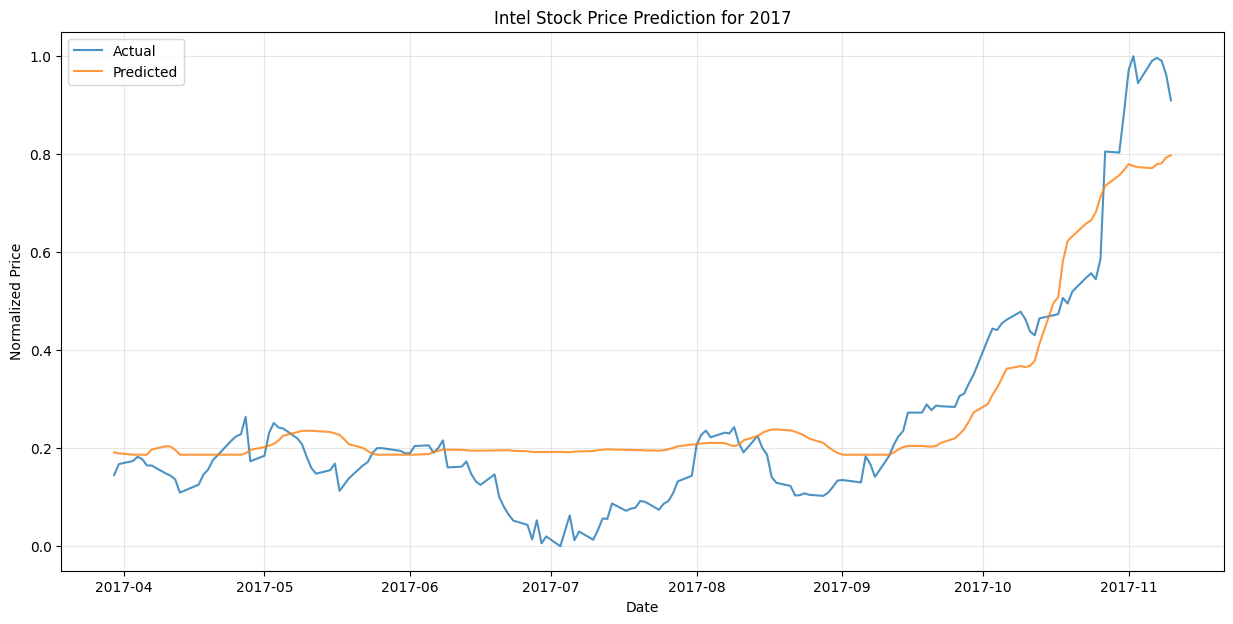


Metrics:
MSE: 0.008718239905068686
MAE: 0.07553365346003789
R2: 0.8273984545991796


In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Create DataFrame for visualization
test_dates = test_df['Date'][-len(predictions):]
pred_df = pd.DataFrame(index=test_dates)
pred_df['Predicted'] = predictions.flatten()
pred_df['Actual'] = y_test

# Plot results
plt.figure(figsize=(15,7))
plt.plot(pred_df.index, pred_df['Actual'], label='Actual', alpha=0.8)
plt.plot(pred_df.index, pred_df['Predicted'], label='Predicted', alpha=0.8)
plt.title('Intel Stock Price Prediction for 2017')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate metrics
print('\nMetrics:')
print('MSE:', mean_squared_error(pred_df['Actual'], pred_df['Predicted']))
print('MAE:', mean_absolute_error(pred_df['Actual'], pred_df['Predicted']))
print('R2:', r2_score(pred_df['Actual'], pred_df['Predicted']))

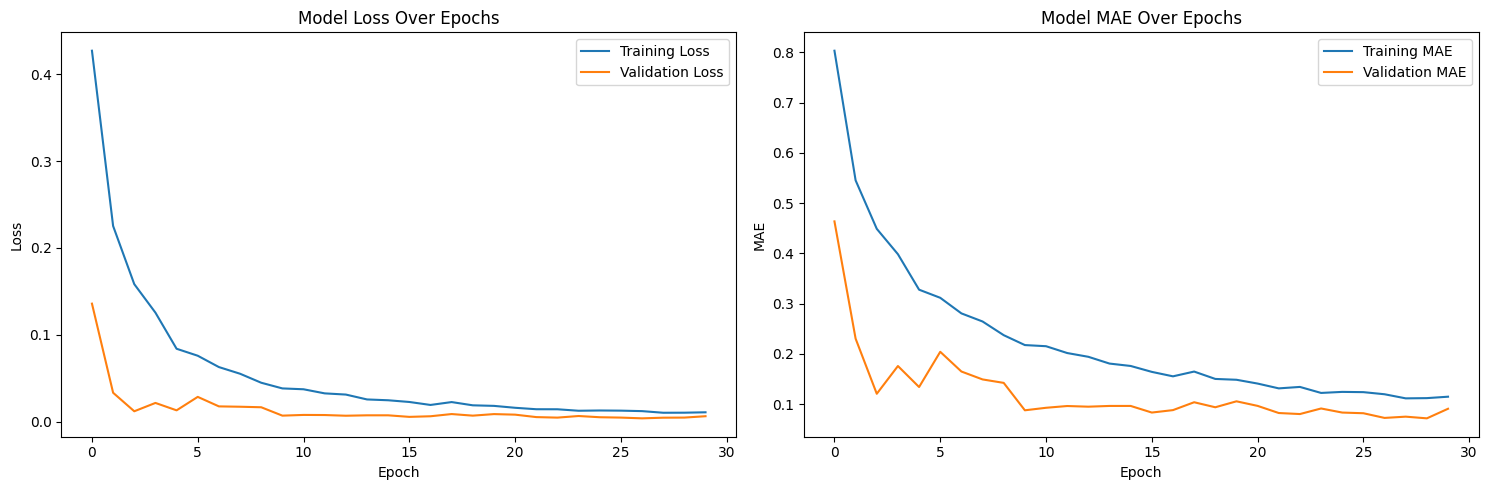

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Metrics plot
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def analyze_sentiment_impact(df):
    # Correlation analysis
    plt.figure(figsize=(12, 6))

    # Calculate price changes
    df['price_change'] = df['Close'].pct_change()

    # Correlation between sentiment and price changes
    correlation = df['rolling_sentiment'].corr(df['price_change'])

    # Scatter plot
    plt.scatter(df['rolling_sentiment'], df['price_change'], alpha=0.5)
    plt.title(f'Sentiment vs Price Change (Correlation: {correlation:.3f})')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Price Change (%)')
    plt.grid(True, alpha=0.3)

    return correlation

In [ ]:
def plot_technical_indicators(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    # Price and Moving Averages
    ax1.plot(df['Close'], label='Close Price')
    ax1.plot(df['MA20'], label='20-day MA')
    ax1.plot(df['MA50'], label='50-day MA')
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # RSI
    ax2.plot(df['RSI'], color='purple')
    ax2.axhline(y=70, color='r', linestyle='--')
    ax2.axhline(y=30, color='g', linestyle='--')
    ax2.set_title('RSI Indicator')

    # MACD
    ax3.plot(df['MACD'], label='MACD')
    ax3.plot(df['Signal_Line'], label='Signal Line')
    ax3.bar(df.index, df['MACD_Hist'], color='gray', alpha=0.3)
    ax3.set_title('MACD')
    ax3.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_prediction_errors(actual, predicted, dates):
    errors = actual - predicted

    plt.figure(figsize=(15, 6))
    plt.plot(dates, errors, label='Prediction Error')
    plt.fill_between(dates, errors, 0, alpha=0.3)
    plt.title('Prediction Errors Over Time')
    plt.xlabel('Date')
    plt.ylabel('Error Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate error statistics
    print("\nError Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Std Error: {np.std(errors):.4f}")
    print(f"Max Error: {np.max(errors):.4f}")
    print(f"Min Error: {np.min(errors):.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def bar_plot_top_sentiment_impacts(news_df, price_df):
    # Merge news with price changes
    news_df['next_day_return'] = price_df['Close'].pct_change().shift(-1)

    # Sort by absolute impact
    news_df['abs_impact'] = abs(news_df['sentiment_score'] * news_df['next_day_return'])
    top_impact_news = news_df.nlargest(10, 'abs_impact')

    # Plot bar chart
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='abs_impact',
        y='title',
        data=top_impact_news,
        palette='viridis'
    )

    plt.title('Top 10 Berita yang paling berpengaruh')
    plt.xlabel('Absolute Impact')
    plt.ylabel('News Title')
    plt.show()

In [ ]:
def plot_sentiment_distribution(df):
    plt.figure(figsize=(12, 6))

    # Sentiment distribution
    sns.histplot(df['rolling_sentiment'], bins=30)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')

    # Add mean and median lines
    plt.axvline(df['rolling_sentiment'].mean(), color='r', linestyle='--',
                label=f'Mean: {df["rolling_sentiment"].mean():.3f}')
    plt.axvline(df['rolling_sentiment'].median(), color='g', linestyle='--',
                label=f'Median: {df["rolling_sentiment"].median():.3f}')
    plt.legend()
    plt.show()

In [ ]:
def analyze_volatility_volume(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Volatility over time
    ax1.plot(df['Volatility'], color='red')
    ax1.set_title('Price Volatility Over Time')
    ax1.set_ylabel('Volatility')

    # Volume and price
    ax2.bar(df.index, df['Volume'], alpha=0.3, label='Volume')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df.index, df['Close'], color='red', label='Price')
    ax2.set_title('Volume and Price Relationship')

    plt.tight_layout()
    plt.show()

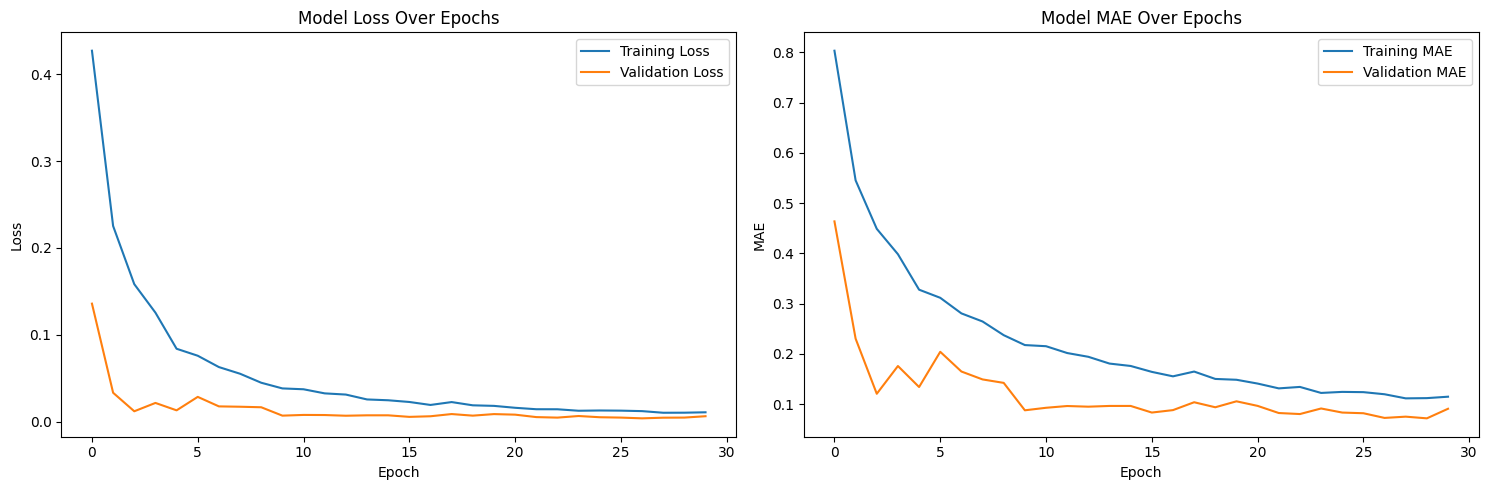

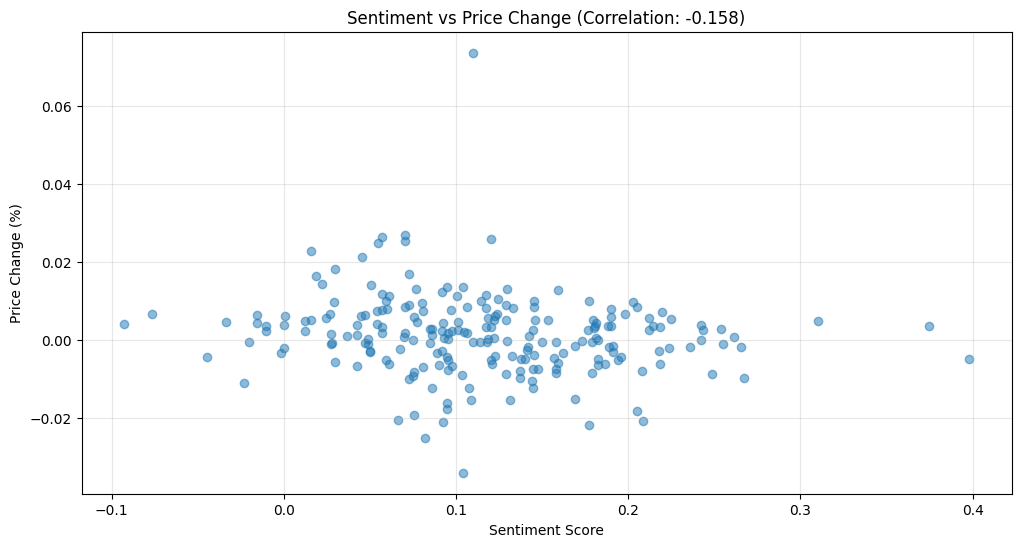

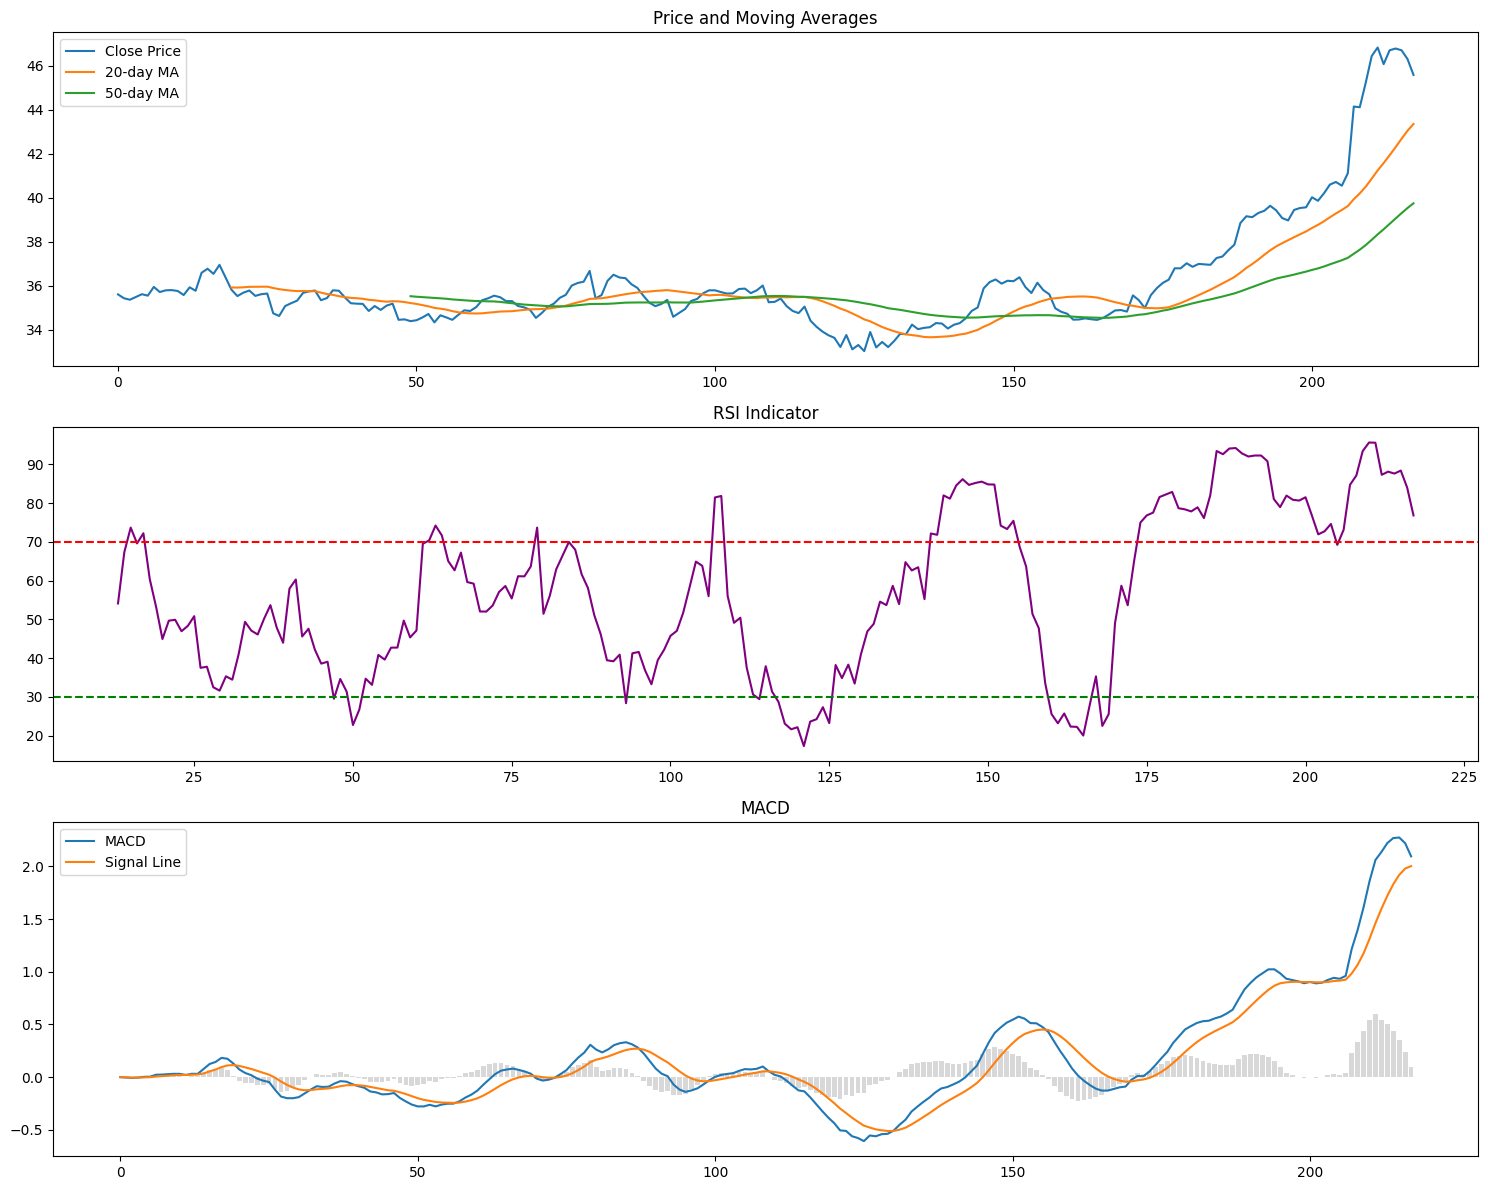


Top 10 Most Impactful News:

Date: 2017-10-10 00:00:00
Title: Intel Accelerates Development of Artificial Intelligence Solutions with Open Neural Network Exchange Support
Sentiment Score: 0.485
Next Day Return: 7.38%

Date: 2017-04-11 00:00:00
Title: Intel Technology to Redefine Cricket Fan and Player Experiences for the Upcoming ICC Champions Trophy 2017
Sentiment Score: 0.561
Next Day Return: -3.42%

Date: 2017-06-21 00:00:00
Title: IOC and Intel Announce Worldwide TOP Partnership Through 2024
Sentiment Score: 0.622
Next Day Return: 2.48%

Date: 2017-05-24 00:00:00
Title: Intel Extends Advanced Analytics to Grand Challenge of Genomics
Sentiment Score: 0.717
Next Day Return: -1.83%

Date: 2017-02-08 00:00:00
Title: Intel Unveils Deep Learning Library for Apache Spark
Sentiment Score: 0.405
Next Day Return: -2.53%

Date: 2017-06-01 00:00:00
Title: Intel Delivers Virtual Reality Experiences to Fans in 3-Year Partnership with Major League Baseball
Sentiment Score: 0.354
Next Day Return:

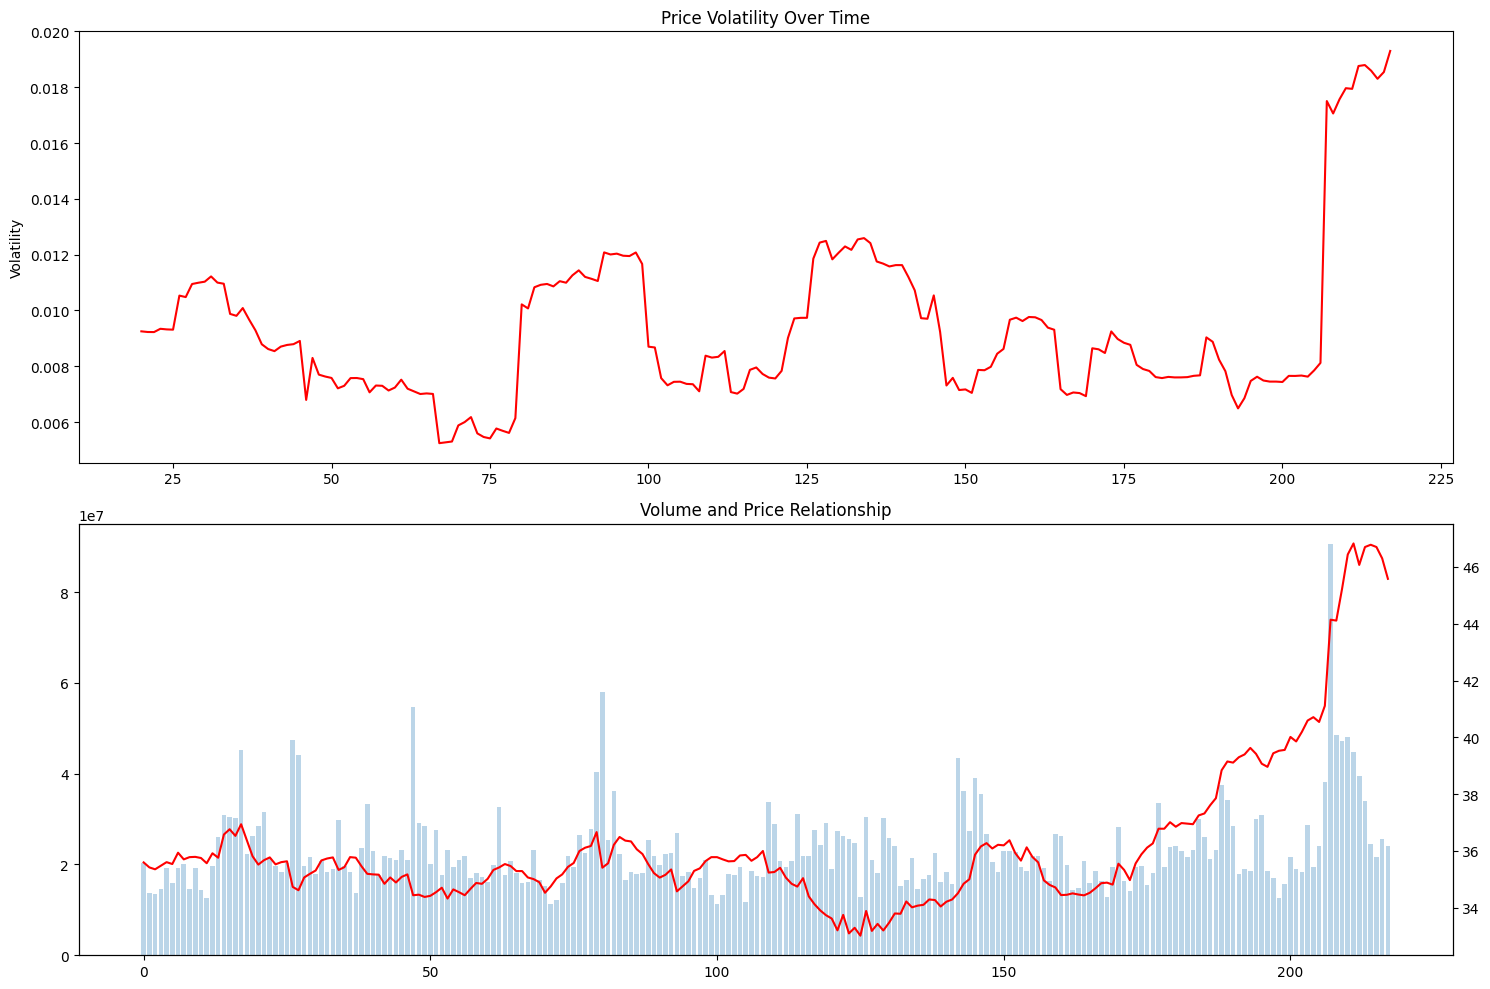

In [ ]:
# Plot all analyses
plot_training_history(history)
correlation = analyze_sentiment_impact(test_df)
plot_technical_indicators(test_df)
analyze_top_sentiment_impacts(news_2017_df, test_df)
analyze_volatility_volume(test_df)

<ipython-input-41-ff5344ab58a5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


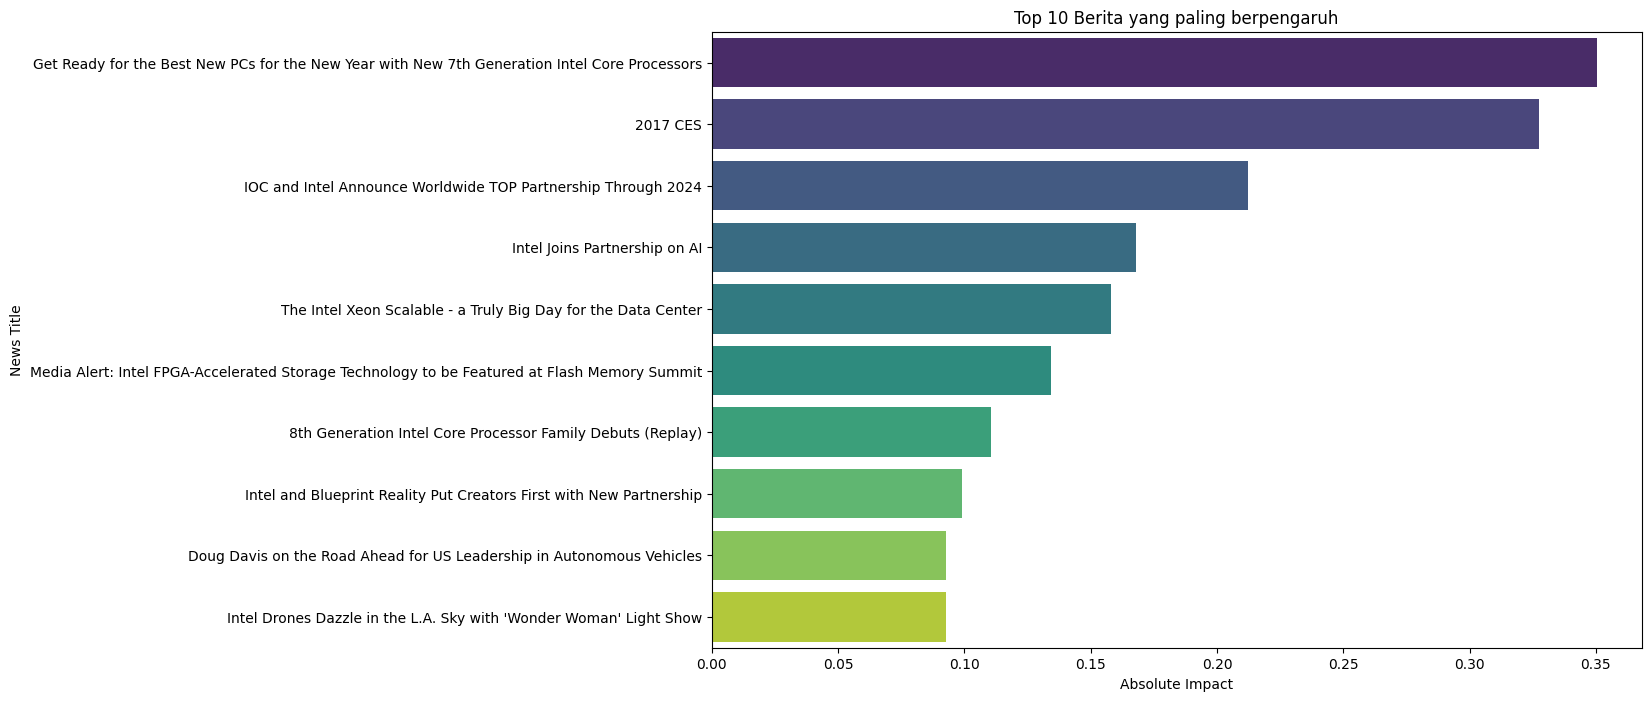

In [ ]:
bar_plot_top_sentiment_impacts(news_2017_df, stock_df)